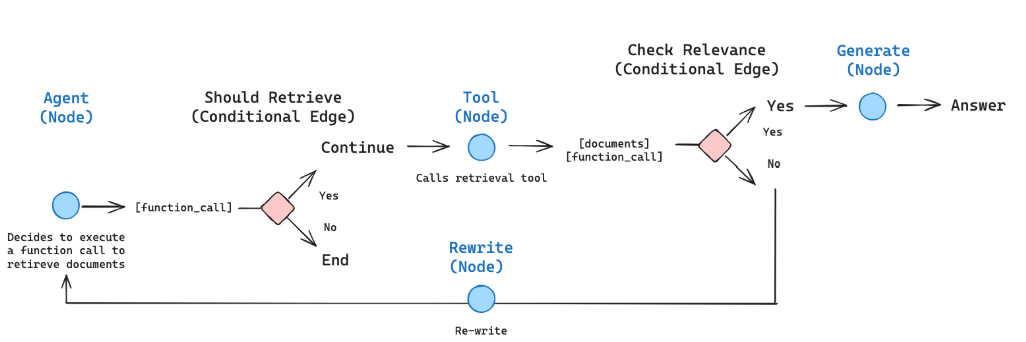

#**Required packages**

In [1]:
!pip install langchain_core langchain_community langgraph langchain_groq langchain_huggingface langchain-chroma


##**Imports**

In [2]:
# for states / pydantic classes
from typing import Annotated, Literal, Sequence, TypedDict

# for structured output
from langchain_core.pydantic_v1 import BaseModel, Field

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# prompt, history and parser
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [4]:
# document loader , text splitter and vectorDB
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import Chroma

In [5]:
# Graph , tools
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages


#**LLM and Embedding model**

In [6]:
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
groq_api_key = userdata.get('groq_api_key')

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,
             model="llama-3.3-70b-versatile")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#**Retriever**

##**Docs loading**

In [9]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]

In [10]:
docs_list = [item for sublist in docs for item in sublist]

##**Text splitter**

In [12]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.5 MB/s eta 0:00:00


In [13]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)

doc_splits = text_splitter.split_documents(docs_list)

##**Vector DB**

In [14]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

##**Retriever tool**

In [15]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

#**Graph workflow**

##**Agent state**

In [16]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

##**Node functions**

In [19]:
def grade_documents(state : AgentState)-> Literal["generate", "rewrite"]:

    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # pydantic class
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # llm with structured output
    grader = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # grader chain
    chain = prompt | grader


    messages = state["messages"]

    # retrieved docs
    last_message = messages[-1]
    docs = last_message.content

    # user query
    question = messages[0].content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite" #this should be a node name

In [20]:
def agent(state : AgentState):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    model = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [21]:
def rewrite(state : AgentState):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")

    # extract user query
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")
    response = model.invoke(msg)
    return {"messages": [response]}

In [23]:
def generate(state : AgentState):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


##**Graph DAG**

In [24]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)  # agent

retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval

workflow.add_node("rewrite", rewrite)  # Re-writing the question

workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant

workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

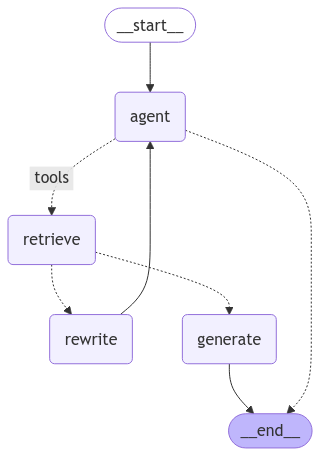

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#**Testing Examples**

In [26]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6pen', 'function': {'arguments': '{"query": "Lilian Weng types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 280, 'total_tokens': 303, 'completion_time': 0.083636364, 'prompt_time': 0.038744642, 'queue_time': 0.246895205, 'total_time': 0.122381006}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-39eab55a-fb7f-41f8-a9b8-b918c0d4341e-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Lilian Weng types of agent memory'}, 'id': 'call_6pen', 'type': 'tool_call'}], usage_metadata={'input_tokens': 280, 'output_tokens': 23, 'total_tokens': 303})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'mes

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Lilian Weng discusses the importance of memory in agent '
                'design, but does not explicitly state the types of agent '
                'memory. According to the context, the types of memory are '
                'mentioned in the context of human brains, not specifically '
                'agent memory. The human brain types of memory are not '
                'explicitly listed in the provided context.']}
'\n---\n'
